In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import os
from PIL import Image
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


# Prepare the data

In [2]:
# Paths
mario_path = 'data/mario/'
luigi_path = 'data/luigi/'
toad_path = 'data/toad/'

# Load and preprocess images
img_size = (128, 128)

def process_images(image_path):
    images = [Image.open(image_path + img).convert('RGB') for img in os.listdir(image_path)]
    images_resized = [img.resize(img_size) for img in images]
    images_array = [np.array(img)/255.0 for img in images_resized]
    return images_array

mario_arrays = process_images(mario_path)
luigi_arrays = process_images(luigi_path)
toad_arrays = process_images(toad_path)

In [10]:
from tensorflow.keras.utils import to_categorical

# Combine all image arrays and labels
all_data = np.array(mario_arrays + luigi_arrays + toad_arrays)
# Create numeric labels: Mario: 0, Luigi: 1, Toad: 2
labels_numeric = np.concatenate([np.zeros(len(mario_arrays)), np.ones(len(luigi_arrays)), 2*np.ones(len(toad_arrays))])
# One-hot encode the labels
labels_one_hot = to_categorical(labels_numeric, num_classes=3)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data, labels_one_hot, test_size=0.2, random_state=42, shuffle=True)


In [11]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)


# Train the model

In [12]:
# Build the multiclass classification model
model_multi = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Increased dropout
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Increased dropout
    
    Flatten(),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), name='embs'),  # L2 regularization and reduced neurons
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(3, activation='softmax')  # 3 units for 3 classes
])

#using early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_multi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
#   model fit early stopping
# model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
history = model_multi.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop])
test_loss, test_acc = model_multi.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


Epoch 1/50
62/62 [==============================] - 15s 221ms/step - loss: 2.5195 - accuracy: 0.7711 - val_loss: 15.1346 - val_accuracy: 0.4744
Epoch 2/50
62/62 [==============================] - 13s 216ms/step - loss: 1.6347 - accuracy: 0.9053 - val_loss: 18.9299 - val_accuracy: 0.4744
Epoch 3/50
62/62 [==============================] - 13s 213ms/step - loss: 1.1644 - accuracy: 0.9473 - val_loss: 26.5636 - val_accuracy: 0.4744
Epoch 4/50
62/62 [==============================] - 13s 212ms/step - loss: 0.8326 - accuracy: 0.9631 - val_loss: 25.4956 - val_accuracy: 0.4744
Epoch 5/50
62/62 [==============================] - 12s 200ms/step - loss: 0.7221 - accuracy: 0.9585 - val_loss: 37.7664 - val_accuracy: 0.4744
Epoch 6/50
62/62 [==============================] - 13s 217ms/step - loss: 0.7256 - accuracy: 0.9595 - val_loss: 16.1530 - val_accuracy: 0.4744
Epoch 7/50
62/62 [==============================] - 14s 222ms/step - loss: 0.6699 - accuracy: 0.9698 - val_loss: 16.6594 - val_accuracy:

In [15]:
model_multi.save('model/mario_luigi_toad_model.h5')

# Confusion Matrix

16/16 [==============================] - 1s 44ms/step


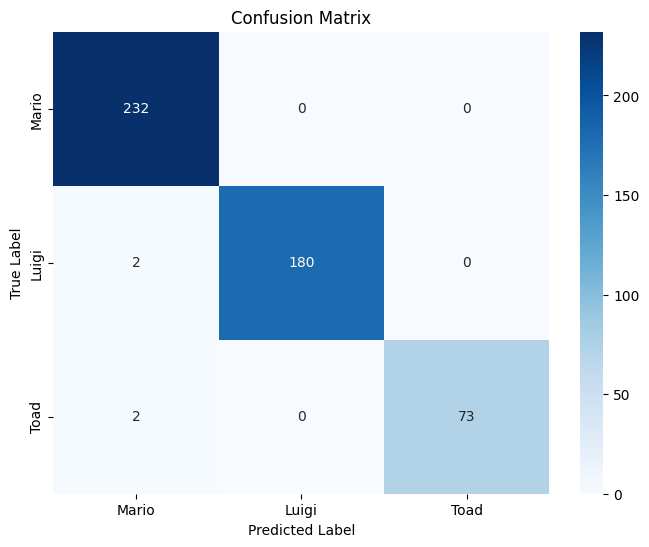

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred_probs = model_multi.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mario', 'Luigi', 'Toad'], 
            yticklabels=['Mario', 'Luigi', 'Toad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Display images

1/1 [==============================] - 0s 57ms/step


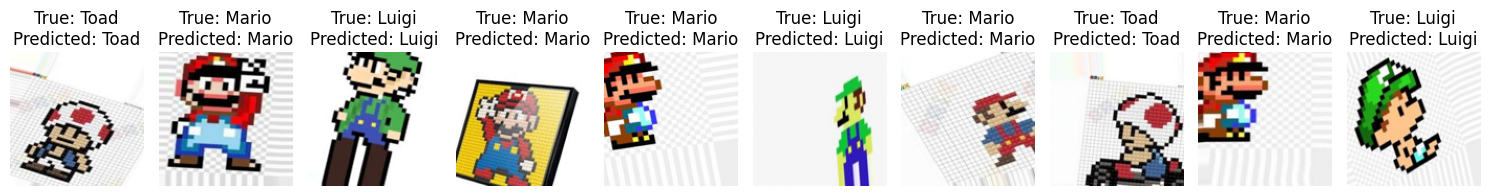

In [20]:
import matplotlib.pyplot as plt
import random

# Define a function to decode one-hot encoded labels back to string labels
def decode_label(one_hot_label):
    index = np.argmax(one_hot_label)
    return ['Mario', 'Luigi', 'Toad'][index]

# Randomly select a few images from the test set (e.g., 5 images)
num_images_to_display = 10
indices = np.random.choice(range(X_test.shape[0]), size=num_images_to_display, replace=False)
selected_images = X_test[indices]
selected_true_labels = y_test[indices]

# Predict the labels using the model
predicted_probs = model_multi.predict(selected_images)
predicted_labels = [decode_label(probs) for probs in predicted_probs]
true_labels = [decode_label(label) for label in selected_true_labels]

# Display the images along with true and predicted labels
plt.figure(figsize=(15, 5))
for idx, (img, true_label, pred_label) in enumerate(zip(selected_images, true_labels, predicted_labels), start=1):
    plt.subplot(1, num_images_to_display, idx)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
